In [1]:
import os
import sys
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from database import DB
from analysis import MLP, xyFeature
from analysis.feature import expand_N_last_game, num_win_N_last_game, win_rate_N_last_game
from utils import normal

In [2]:
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)

In [3]:
db = DB()
db.initialise()
col_to_use = ['league_name', 'year', 'season', 'date', 'set_number', 
              'team_1', 'team_2', 'corresponding_team',
              'wdl', 'side', 'game_length','team_kills',
              'team_deaths','team_baron_kills', 'team_dragon_kills',
              'team_rift_kills', 'team_tower_kills', 'team_inhib_kills',
             'team_total_gold', 'team_minion_kills']
temp_df = db.get_table('view_set_match_info_concat', col_to_use)
df = temp_df.dropna(subset=col_to_use)
#, 'top_player', 'jg_player', 'mid_player', 'bot_player', 'sup_player'

In [4]:
list(df.columns)

['league_name',
 'year',
 'season',
 'date',
 'set_number',
 'team_1',
 'team_2',
 'corresponding_team',
 'wdl',
 'side',
 'game_length',
 'team_kills',
 'team_deaths',
 'team_baron_kills',
 'team_dragon_kills',
 'team_rift_kills',
 'team_tower_kills',
 'team_inhib_kills',
 'team_total_gold',
 'team_minion_kills']

In [5]:
gamelength_norm_cols = ['team_kills','team_deaths','team_baron_kills', 
                        'team_dragon_kills','team_rift_kills', 
                        'team_total_gold','team_minion_kills']
df[gamelength_norm_cols] = normal(df, gamelength_norm_cols, 'game_length')


min_max_cols = ['team_tower_kills', 'team_inhib_kills']
df[min_max_cols] = normal(df, min_max_cols, 'minmax')

In [6]:
df = expand_N_last_game(df, gamelength_norm_cols+min_max_cols, 3)
#df = expand_N_last_game(df, ['top_player', 'jg_player', 'mid_player', 'bot_player', 'sup_player', 'side'], 1)

In [7]:
df.head()

,league_name,year,season,date,set_number,team_1,team_2,corresponding_team,wdl,side,game_length,team_kills,team_deaths,team_baron_kills,team_dragon_kills,team_rift_kills,team_tower_kills,team_inhib_kills,team_total_gold,team_minion_kills,team_kills__1,team_deaths__1,team_baron_kills__1,team_dragon_kills__1,team_rift_kills__1,team_total_gold__1,team_minion_kills__1,team_tower_kills__1,team_inhib_kills__1,team_kills__2,team_deaths__2,team_baron_kills__2,team_dragon_kills__2,team_rift_kills__2,team_total_gold__2,team_minion_kills__2,team_tower_kills__2,team_inhib_kills__2,team_kills__3,team_deaths__3,team_baron_kills__3,team_dragon_kills__3,team_rift_kills__3,team_total_gold__3,team_minion_kills__3,team_tower_kills__3,team_inhib_kills__3
0,BL,2020,spring,2020-01-21,1,Sector One,Timeout Esports,Timeout Esports,L,red,1887.0,0.476948,0.540541,0.000000,0.095390,0.000000,0.000000,0.0000,1558.028617,22.861685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BL,2020,spring,2020-01-28,1,Timeout Esports,KV Mechelen,Timeout Esports,W,red,1831.0,0.950300,0.524304,0.000000,0.098307,0.000000,0.636364,0.0625,1897.323867,24.019661,0.476948,0.540541,0.000000,0.095390,0.000000,1558.028617,22.861685,0.000000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BL,2020,spring,2020-01-28,1,Timeout Esports,Brussels Guardians,Timeout Esports,W,red,1917.0,0.625978,0.344288,0.031299,0.156495,0.062598,0.909091,0.1250,1862.284820,22.879499,0.950300,0.524304,0.000000,0.098307,0.000000,1897.323867,24.019661,0.636364,0.0625,0.476948,0.540541,0.000000,0.095390,0.000000,1558.028617,22.861685,0.000000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BL,2020,spring,2020-02-11,1,RSCA,Timeout Esports,Timeout Esports,W,red,1912.0,0.564854,0.219665,0.031381,0.125523,0.062762,0.727273,0.0625,1823.221757,23.410042,0.625978,0.344288,0.031299,0.156495,0.062598,1862.284820,22.879499,0.909091,0.1250,0.950300,0.524304,0.000000,0.098307,0.000000,1897.323867,24.019661,0.636364,0.0625,0.476948,0.540541,0.0,0.095390,0.0,1558.028617,22.861685,0.000000,0.0000
4,BL,2020,spring,2020-02-25,1,Timeout Esports,Brussels Guardians,Timeout Esports,W,red,1960.0,0.673469,0.336735,0.030612,0.122449,0.061224,1.000000,0.1250,1913.265306,23.908163,0.564854,0.219665,0.031381,0.125523,0.062762,1823.221757,23.410042,0.727273,0.0625,0.625978,0.344288,0.031299,0.156495,0.062598,1862.284820,22.879499,0.909091,0.1250,0.950300,0.524304,0.0,0.098307,0.0,1897.323867,24.019661,0.636364,0.0625


In [8]:
df = num_win_N_last_game(df, rolling_window=3)

In [9]:
df = win_rate_N_last_game(df, rolling_window=3)
df = win_rate_N_last_game(df, opponent=True)

In [10]:
df.shape

(23464, 50)

In [11]:
df = df.dropna()

In [12]:
drop_cols = ['league_name', 'year', 'season', 'date', 'set_number', 
             'team_1', 'team_2' ,'corresponding_team', 'game_length',
            'team_kills', 'team_deaths', 'team_baron_kills', 
            'team_dragon_kills', 'team_rift_kills', 'team_total_gold',
            'team_minion_kills', 'team_tower_kills', 'team_inhib_kills']
#cat_cols = ['side', 'top_player', 'jg_player', 'mid_player', 'bot_player', 'sup_player']
cat_cols = ['side']

y_col = ['wdl']

cont_cols = list(set(list(df.columns)) - set(drop_cols) - set(cat_cols) - set(y_col))

In [13]:
xy = xyFeature(df, cat_cols, cont_cols, y_col, gpu=True)
cats, conts, y = xy.prepare_XY()
emb_szs, n_cont, out_sz = xy.get_size()

In [14]:
torch.manual_seed(123)
model = MLP(emb_szs, n_cont, out_sz, [200, 100, 100], p=0.5).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
#batch_size = temp_df.shape[0]
train_size = df[df['year']!=2020].shape[0]
val_size = df[(df['year']==2020) & (df['season']=='spring')].shape[0]
test_size = df[(df['year']==2020) & (df['season']=='summer')].shape[0]

cat_train = cats[:train_size]
con_train = conts[:train_size]
y_train = y[:train_size]

cat_valid = cats[train_size: train_size+val_size]
con_valid = conts[train_size: train_size+val_size]
y_valid = y[train_size: train_size+val_size]

cat_test = cats[train_size+val_size: train_size+val_size+test_size]
con_test = conts[train_size+val_size: train_size+val_size+test_size]
y_test = y[train_size+val_size: train_size+val_size+test_size]

In [16]:
print(train_size, val_size, test_size)

12999 2296 2597


In [17]:
import time
start_time = time.time()

epochs = 10000
costs = []
val_costs = []
count_val_cost_up = 0

for epoch in range(epochs):
    y_pred = model.forward(cat_train, con_train)
    cost = criterion(y_pred, y_train)
    costs.append(cost)
    
#     # Learning Rate Decay
#     if len(costs) > 100:
#         temp_cost_list = [cost.item() for cost in costs[-100:]]
#         if statistics.mean(temp_cost_list) - cost.item() < 0:
#             print(f'Learning Rate Decayed')
#             optimizer.param_groups[0]['lr'] *= 0.7
            
    # Check Validation costs 
    with torch.no_grad():
        val_y_pred = model.forward(cat_valid, con_valid)
        val_cost = criterion(val_y_pred, y_valid)
        val_costs.append(val_cost)
    
    # print train, validation cost
    if epoch % 100 == 0:
        print(f'epoch: {epoch}, cost: {cost:.8f}, val_cost: {val_cost:.8f}')
        if len(costs) > 100:
            temp_cost_list = [cost.item() for cost in costs[-100:]]
            #if statistics.mean(temp_cost_list) - cost.item() < 0:
            if min(temp_cost_list) - cost.item() < 0:
                print(f'Learning Rate Decayed')
                optimizer.param_groups[0]['lr'] *= 0.5
    
    
    # if val cost go up 20 times in a row then stop
    if len(val_costs) > 0:
        if val_costs[-1] < val_cost:
            count_val_cost_up += 1
        else:
            count_val_cost_up = 0
            
    if count_val_cost_up == 20:
        print('validation cost keep going up so break!')
        break

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print(f'Duration: {(time.time() - start_time):.0f} seconds')

epoch: 0, cost: 0.71718413, val_cost: 0.70423096
epoch: 100, cost: 0.62967402, val_cost: 0.66311222
Learning Rate Decayed
epoch: 200, cost: 0.60556245, val_cost: 0.66849631
epoch: 300, cost: 0.58997250, val_cost: 0.67893022
Learning Rate Decayed
epoch: 400, cost: 0.57798207, val_cost: 0.69003779
Learning Rate Decayed
epoch: 500, cost: 0.56980824, val_cost: 0.68703276
Learning Rate Decayed
epoch: 600, cost: 0.56421220, val_cost: 0.68678015
Learning Rate Decayed
epoch: 700, cost: 0.56349874, val_cost: 0.69112629
Learning Rate Decayed
epoch: 800, cost: 0.56438500, val_cost: 0.68724591
Learning Rate Decayed
epoch: 900, cost: 0.56355172, val_cost: 0.69384319
Learning Rate Decayed
epoch: 1000, cost: 0.56459123, val_cost: 0.69676542
Learning Rate Decayed
epoch: 1100, cost: 0.56391078, val_cost: 0.69788575
Learning Rate Decayed
epoch: 1200, cost: 0.56492954, val_cost: 0.69477850
Learning Rate Decayed
epoch: 1300, cost: 0.56664783, val_cost: 0.69181621
Learning Rate Decayed
epoch: 1400, cost: 0

Text(0.5, 0, 'epoch')

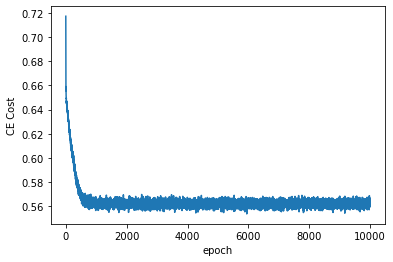

In [18]:
plt.plot(range(epochs), costs)
plt.ylabel('CE Cost')
plt.xlabel('epoch')

In [19]:
with torch.no_grad():
    y_pred = model(cat_test, con_test)
    cost = criterion(y_pred, y_test)
print(f'Cross Entropy Loss: {cost:.8f}')
    

Cross Entropy Loss: 0.71679902


In [20]:
rows = 2000
correct = 0
print(f'{"Model output":36} ARGMAX    Y_test')
for i in range(rows):
    print(f'{str(y_pred[i]):36}  {y_pred[i].argmax():^7}{y_test[i]:^7}')
    if y_pred[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


Model output                         ARGMAX    Y_test
tensor([0.2543, 0.7457], device='cuda:0')     1      1   
tensor([0.4866, 0.5134], device='cuda:0')     1      1   
tensor([1.4590e-05, 9.9999e-01], device='cuda:0')     1      0   
tensor([0.6570, 0.3430], device='cuda:0')     0      0   
tensor([0.0202, 0.9798], device='cuda:0')     1      1   
tensor([0.0731, 0.9269], device='cuda:0')     1      0   
tensor([1.0000e+00, 4.2557e-14], device='cuda:0')     0      0   
tensor([0.4828, 0.5172], device='cuda:0')     1      0   
tensor([9.9993e-01, 7.2587e-05], device='cuda:0')     0      1   
tensor([0.3381, 0.6619], device='cuda:0')     1      1   
tensor([0.1391, 0.8609], device='cuda:0')     1      0   
tensor([0.0240, 0.9760], device='cuda:0')     1      0   
tensor([0.1721, 0.8279], device='cuda:0')     1      1   
tensor([0.8074, 0.1926], device='cuda:0')     0      0   
tensor([0.9962, 0.0038], device='cuda:0')     0      1   
tensor([0.9987, 0.0013], device='cuda:0')     0     

tensor([0.8467, 0.1533], device='cuda:0')     0      0   
tensor([9.9915e-01, 8.4730e-04], device='cuda:0')     0      0   
tensor([0.9917, 0.0083], device='cuda:0')     0      0   
tensor([1.0000e+00, 1.4218e-06], device='cuda:0')     0      0   
tensor([0.9983, 0.0017], device='cuda:0')     0      0   
tensor([9.9999e-01, 7.5845e-06], device='cuda:0')     0      0   
tensor([0.9975, 0.0025], device='cuda:0')     0      1   
tensor([0.0461, 0.9539], device='cuda:0')     1      1   
tensor([1.0000e+00, 5.8497e-08], device='cuda:0')     0      1   
tensor([0.9954, 0.0046], device='cuda:0')     0      1   
tensor([0.0674, 0.9326], device='cuda:0')     1      1   
tensor([0.1270, 0.8730], device='cuda:0')     1      1   
tensor([0.0181, 0.9819], device='cuda:0')     1      0   
tensor([0.0035, 0.9965], device='cuda:0')     1      0   
tensor([9.9979e-01, 2.1181e-04], device='cuda:0')     0      0   
tensor([0.9862, 0.0138], device='cuda:0')     0      1   
tensor([0.0166, 0.9834], device=

tensor([1.0000e+00, 1.6196e-09], device='cuda:0')     0      0   
tensor([1.0000e+00, 9.4016e-10], device='cuda:0')     0      1   
tensor([9.9997e-01, 2.6811e-05], device='cuda:0')     0      1   
tensor([0.5326, 0.4674], device='cuda:0')     0      0   
tensor([0.9328, 0.0672], device='cuda:0')     0      0   
tensor([0.1210, 0.8790], device='cuda:0')     1      0   
tensor([0.9893, 0.0107], device='cuda:0')     0      0   
tensor([0.3223, 0.6777], device='cuda:0')     1      0   
tensor([0.4513, 0.5487], device='cuda:0')     1      0   
tensor([1.9578e-05, 9.9998e-01], device='cuda:0')     1      0   
tensor([0.2054, 0.7946], device='cuda:0')     1      0   
tensor([0.6913, 0.3087], device='cuda:0')     0      1   
tensor([0.0180, 0.9820], device='cuda:0')     1      1   
tensor([1.0000e+00, 4.8042e-11], device='cuda:0')     0      1   
tensor([0.8413, 0.1587], device='cuda:0')     0      0   
tensor([0.8482, 0.1518], device='cuda:0')     0      0   
tensor([0.7586, 0.2414], device=

tensor([1.2534e-04, 9.9987e-01], device='cuda:0')     1      1   
tensor([0.0145, 0.9855], device='cuda:0')     1      1   
tensor([0.9405, 0.0595], device='cuda:0')     0      1   
tensor([3.1351e-04, 9.9969e-01], device='cuda:0')     1      1   
tensor([0.0012, 0.9988], device='cuda:0')     1      0   
tensor([1.0000e+00, 3.8335e-06], device='cuda:0')     0      0   
tensor([0.0893, 0.9107], device='cuda:0')     1      0   
tensor([0.7520, 0.2480], device='cuda:0')     0      0   
tensor([0.9027, 0.0973], device='cuda:0')     0      0   
tensor([0.8263, 0.1737], device='cuda:0')     0      1   
tensor([0.6301, 0.3699], device='cuda:0')     0      1   
tensor([9.9999e-01, 1.3146e-05], device='cuda:0')     0      1   
tensor([0.0284, 0.9716], device='cuda:0')     1      1   
tensor([0.9452, 0.0548], device='cuda:0')     0      0   
tensor([0.0011, 0.9989], device='cuda:0')     1      0   
tensor([0.1763, 0.8237], device='cuda:0')     1      1   
tensor([0.1484, 0.8516], device='cuda:0'

tensor([1.0000e+00, 4.1199e-06], device='cuda:0')     0      0   
tensor([0.4061, 0.5939], device='cuda:0')     1      0   
tensor([0.0128, 0.9872], device='cuda:0')     1      1   
tensor([0.9255, 0.0745], device='cuda:0')     0      0   
tensor([0.0319, 0.9681], device='cuda:0')     1      0   
tensor([1.0000e+00, 2.5841e-06], device='cuda:0')     0      0   
tensor([9.9948e-01, 5.2206e-04], device='cuda:0')     0      0   
tensor([0.0302, 0.9698], device='cuda:0')     1      1   
tensor([8.8626e-04, 9.9911e-01], device='cuda:0')     1      1   
tensor([0.9986, 0.0014], device='cuda:0')     0      0   
tensor([0.6301, 0.3699], device='cuda:0')     0      0   
tensor([0.0017, 0.9983], device='cuda:0')     1      0   
tensor([9.4528e-10, 1.0000e+00], device='cuda:0')     1      1   
tensor([3.0130e-09, 1.0000e+00], device='cuda:0')     1      1   
tensor([1.4320e-05, 9.9999e-01], device='cuda:0')     1      1   
tensor([0.0738, 0.9262], device='cuda:0')     1      1   
tensor([0.0025, 

tensor([0.5331, 0.4669], device='cuda:0')     0      0   
tensor([0.5307, 0.4693], device='cuda:0')     0      0   
tensor([9.9999e-01, 7.1921e-06], device='cuda:0')     0      0   
tensor([0.9938, 0.0062], device='cuda:0')     0      0   
tensor([0.9800, 0.0200], device='cuda:0')     0      1   
tensor([0.8498, 0.1502], device='cuda:0')     0      1   
tensor([0.7858, 0.2142], device='cuda:0')     0      1   
tensor([0.0020, 0.9980], device='cuda:0')     1      1   
tensor([0.6073, 0.3927], device='cuda:0')     0      0   
tensor([0.9972, 0.0028], device='cuda:0')     0      0   
tensor([0.7108, 0.2892], device='cuda:0')     0      1   
tensor([0.4394, 0.5606], device='cuda:0')     1      1   
tensor([3.4349e-08, 1.0000e+00], device='cuda:0')     1      1   
tensor([0.0087, 0.9913], device='cuda:0')     1      1   
tensor([1.1769e-05, 9.9999e-01], device='cuda:0')     1      1   
tensor([1.7186e-05, 9.9998e-01], device='cuda:0')     1      0   
tensor([5.1667e-05, 9.9995e-01], device=

tensor([0.6332, 0.3668], device='cuda:0')     0      0   
tensor([0.9948, 0.0052], device='cuda:0')     0      0   
tensor([0.9867, 0.0133], device='cuda:0')     0      0   
tensor([0.0285, 0.9715], device='cuda:0')     1      1   
tensor([0.9734, 0.0266], device='cuda:0')     0      0   
tensor([0.9099, 0.0901], device='cuda:0')     0      0   
tensor([0.9575, 0.0425], device='cuda:0')     0      1   
tensor([0.0971, 0.9029], device='cuda:0')     1      0   
tensor([0.0086, 0.9914], device='cuda:0')     1      0   
tensor([0.0118, 0.9882], device='cuda:0')     1      1   
tensor([2.3332e-07, 1.0000e+00], device='cuda:0')     1      1   
tensor([2.1638e-08, 1.0000e+00], device='cuda:0')     1      1   
tensor([0.0080, 0.9920], device='cuda:0')     1      1   
tensor([4.5567e-10, 1.0000e+00], device='cuda:0')     1      0   
tensor([1.2709e-11, 1.0000e+00], device='cuda:0')     1      1   
tensor([5.0796e-04, 9.9949e-01], device='cuda:0')     1      1   
tensor([0.8794, 0.1206], device=

tensor([0.0120, 0.9880], device='cuda:0')     1      0   
tensor([0.9151, 0.0849], device='cuda:0')     0      1   
tensor([0.0198, 0.9802], device='cuda:0')     1      0   
tensor([0.9802, 0.0198], device='cuda:0')     0      0   
tensor([0.0042, 0.9958], device='cuda:0')     1      1   
tensor([0.9035, 0.0965], device='cuda:0')     0      0   
tensor([0.8895, 0.1105], device='cuda:0')     0      0   
tensor([9.9986e-01, 1.3778e-04], device='cuda:0')     0      0   
tensor([5.4061e-08, 1.0000e+00], device='cuda:0')     1      1   
tensor([2.3695e-04, 9.9976e-01], device='cuda:0')     1      0   
tensor([1.0000e+00, 1.4092e-07], device='cuda:0')     0      1   
tensor([0.9965, 0.0035], device='cuda:0')     0      1   
tensor([0.0012, 0.9988], device='cuda:0')     1      0   
tensor([0.9033, 0.0967], device='cuda:0')     0      0   
tensor([0.0592, 0.9408], device='cuda:0')     1      0   
tensor([0.0724, 0.9276], device='cuda:0')     1      1   
tensor([9.9999e-01, 5.7600e-06], device=

tensor([9.9977e-01, 2.3486e-04], device='cuda:0')     0      0   
tensor([0.9965, 0.0035], device='cuda:0')     0      0   
tensor([0.9938, 0.0062], device='cuda:0')     0      0   
tensor([0.6668, 0.3332], device='cuda:0')     0      0   
tensor([0.9894, 0.0106], device='cuda:0')     0      0   
tensor([1.0000e+00, 2.1206e-12], device='cuda:0')     0      1   
tensor([0.9934, 0.0066], device='cuda:0')     0      0   
tensor([9.9996e-01, 4.0596e-05], device='cuda:0')     0      0   
tensor([0.9963, 0.0037], device='cuda:0')     0      0   
tensor([0.8414, 0.1586], device='cuda:0')     0      0   
tensor([0.9243, 0.0757], device='cuda:0')     0      0   
tensor([0.9928, 0.0072], device='cuda:0')     0      1   
tensor([0.7844, 0.2156], device='cuda:0')     0      0   
tensor([0.6433, 0.3567], device='cuda:0')     0      1   
tensor([0.6838, 0.3162], device='cuda:0')     0      1   
tensor([9.9934e-01, 6.6005e-04], device='cuda:0')     0      0   
tensor([9.9988e-01, 1.2098e-04], device=

tensor([7.9698e-15, 1.0000e+00], device='cuda:0')     1      1   
tensor([0.0058, 0.9942], device='cuda:0')     1      1   
tensor([2.5462e-09, 1.0000e+00], device='cuda:0')     1      1   
tensor([0.4046, 0.5954], device='cuda:0')     1      0   
tensor([0.0080, 0.9920], device='cuda:0')     1      0   
tensor([0.0887, 0.9113], device='cuda:0')     1      0   
tensor([0.0199, 0.9801], device='cuda:0')     1      0   
tensor([0.2745, 0.7255], device='cuda:0')     1      0   
tensor([0.3367, 0.6633], device='cuda:0')     1      0   
tensor([0.8668, 0.1332], device='cuda:0')     0      0   
tensor([1.0000e+00, 4.2966e-09], device='cuda:0')     0      0   
tensor([0.9972, 0.0028], device='cuda:0')     0      0   
tensor([0.4354, 0.5646], device='cuda:0')     1      0   
tensor([2.4390e-12, 1.0000e+00], device='cuda:0')     1      1   
tensor([0.6581, 0.3419], device='cuda:0')     0      0   
tensor([0.9280, 0.0720], device='cuda:0')     0      0   
tensor([0.0172, 0.9828], device='cuda:0'

tensor([0.9023, 0.0977], device='cuda:0')     0      0   
tensor([0.0019, 0.9981], device='cuda:0')     1      0   
tensor([0.9582, 0.0418], device='cuda:0')     0      1   
tensor([0.9969, 0.0031], device='cuda:0')     0      0   
tensor([0.0016, 0.9984], device='cuda:0')     1      1   
tensor([0.0073, 0.9927], device='cuda:0')     1      1   
tensor([0.0254, 0.9746], device='cuda:0')     1      1   
tensor([0.0145, 0.9855], device='cuda:0')     1      0   
tensor([0.0043, 0.9957], device='cuda:0')     1      1   
tensor([4.0199e-05, 9.9996e-01], device='cuda:0')     1      0   
tensor([0.9738, 0.0262], device='cuda:0')     0      1   
tensor([0.9573, 0.0427], device='cuda:0')     0      0   
tensor([0.9963, 0.0037], device='cuda:0')     0      0   
tensor([0.9988, 0.0012], device='cuda:0')     0      0   
tensor([2.1934e-04, 9.9978e-01], device='cuda:0')     1      0   
tensor([0.9956, 0.0044], device='cuda:0')     0      0   
tensor([0.9270, 0.0730], device='cuda:0')     0      1  

tensor([0.2058, 0.7942], device='cuda:0')     1      1   
tensor([7.6953e-11, 1.0000e+00], device='cuda:0')     1      1   
tensor([0.0107, 0.9893], device='cuda:0')     1      1   
tensor([5.0118e-09, 1.0000e+00], device='cuda:0')     1      1   
tensor([0.0069, 0.9931], device='cuda:0')     1      0   
tensor([0.0117, 0.9883], device='cuda:0')     1      0   
tensor([1.2838e-10, 1.0000e+00], device='cuda:0')     1      0   
tensor([0.0332, 0.9668], device='cuda:0')     1      0   
tensor([0.9690, 0.0310], device='cuda:0')     0      0   
tensor([0.3547, 0.6453], device='cuda:0')     1      0   
tensor([0.9669, 0.0331], device='cuda:0')     0      0   
tensor([0.9075, 0.0925], device='cuda:0')     0      1   
tensor([1.0000e+00, 1.1380e-07], device='cuda:0')     0      1   
tensor([0.9959, 0.0041], device='cuda:0')     0      0   
tensor([0.9835, 0.0165], device='cuda:0')     0      0   
tensor([0.1138, 0.8862], device='cuda:0')     1      0   
tensor([0.9905, 0.0095], device='cuda:0'

[0.6010298728942871,
 0.5988912582397461,
 0.5984823107719421,
 0.6033836007118225,
 0.5989718437194824,
 0.6012028455734253,
 0.5983993411064148,
 0.5946046710014343,
 0.5991948843002319,
 0.5981810688972473]

In [28]:
costs[0].item()

0.6248207688331604

In [ ]:
import time
start_time = time.time()

epochs = 3000
costs = []

for epoch in range(epochs):
    model.train()
    y_pred = model.forward(cat_train, con_train)
    cost = criterion(y_pred, y_train)
    costs.append(cost)
    
    if epoch % 100 == 0:
        print(f'epoch: {epoch}, cost: {cost:.8f}')
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print(f'Duration: {(time.time() - start_time):.0f} seconds')